In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Imports**

In [ ]:
import torch
from torch import nn
import torchvision
import numpy as np
#!pip install timm
import timm
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision.datasets import ImageFolder
import operator
import torchvision.transforms as transforms 
import seaborn as sns

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.ticker as ticker
import itertools

In [ ]:
#!unzip /content/drive/MyDrive/train.zip

In [ ]:
# !unzip /content/drive/MyDrive/test.zip

***Saving the models for further work if need be.***

In [ ]:
#create a directory for models to be saved in /kaggle/working
# if os.path.exists("/kaggle/working/models_archive") == False:
#     os.mkdir("models_archive")
# os.listdir()

In [ ]:
#test -> validation set
#pred -> test set (not labelled)
train_dir = "/content/seg_train"

# pred_dir = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/seg_pred"

BATCH_SIZE = 64
EPOCHS = 7
CLASSES = os.listdir(train_dir)
metric = 0

In [ ]:
#!pip install split-folders
import splitfolders
input_folder = train_dir

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#Train, val, test
splitfolders.ratio(input_folder, output="cell_images2", 
                   seed=42, ratio=(.8, .2), 
                   group_prefix=None) 

Copying files: 14034 files [00:02, 5185.92 files/s]


In [ ]:
train_dir = "/content/cell_images2/train"
test_dir = "/content/cell_images2/val"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

# Tweaking Models

***Function to freeze layers.***

In [ ]:
def model_adjustment(p_model):
    for param in p_model.parameters():
        param.requires_grad=False
    return p_model

***Function to return loss, optimizer and schedulers based on the model.***

In [ ]:
def model_assets(base_model, seed):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
    lrp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    if seed == 0 or seed == 1:
        mls_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2], gamma=0.1)
        return criterion, optimizer, lrp_scheduler, mls_scheduler
    else:
        return criterion, optimizer, lrp_scheduler

***Function to return classifiers. The replacements are done based on best practices and previous experiments that have been generally known to exhibit good results.***

# Defining Models

In [ ]:
def model_archive(seed):
    if seed == 0:
        model = timm.create_model('vit_base_patch16_224', pretrained=True)
        model = model_adjustment(model)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
        
    elif seed == 1:
        model = torchvision.models.vgg19_bn(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=len(CLASSES)),
        )
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed) 
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
        
    
    elif seed == 2:
        model = timm.create_model('ens_adv_inception_resnet_v2', pretrained=True)
        model = model_adjustment(model)
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 3:
        model = torchvision.models.densenet201(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 4:
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        model = model_adjustment(model)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler

In [ ]:
# ViT (Vision Transformer)
model_vit, criterion_vit, optimizer_vit, lrp_scheduler_vit, mls_scheduler_vit = model_archive(seed = 0)

# VGG19 with batch-normalization
#model_vgg, criterion_vgg, optimizer_vgg, lrp_scheduler_vgg, mls_scheduler_vgg = model_archive(seed = 1)

# # Ensemble Adversarial Inception-ResNet v2
# model_eairv, criterion_eairv, optimizer_eairv, lrp_scheduler_eairv = model_archive(seed = 2)

# # DenseNet201 classifier
# model_dn, criterion_dn, optimizer_dn, lrp_scheduler_dn = model_archive(seed = 3)

# # ResNeXt50_32 Classifier
# model_rnx, criterion_rnx, optimizer_rnx, lrp_scheduler_rnx = model_archive(seed = 4)

# Transformations and Augmentations

These transformations are applied to the following models:
* VGG-19 with BatchNormalization
* DenseNet201 classifier
* ResNeXt50 classifier

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
transform_train_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4950, 0.4760, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
    transforms.RandomErasing(p=0.5, scale=(0.05, 0.23), ratio=(0.6, 3.3), inplace=False),
    transforms.RandomApply([AddGaussianNoise(0.05, 0.356)], p=0.5),
])
transform_test_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4950, 0.4760, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
])

These transformations are model specific imported from timm:
* Vision Transformer (ViT)
* Ensemble Adversarial Inception-ResNet v2

In [ ]:
config_vit = resolve_data_config({}, model = model_vit)
transform_vit = create_transform(**config_vit)

# config_eairv = resolve_data_config({}, model = model_eairv)
# transform_eairv = create_transform(**config_eairv)

# Loading Data

In [ ]:
import torch
from torchvision import datasets
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        try:
          original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
          # the image file path
          path = self.imgs[index][0]
          # make a new tuple that includes original and the path
          tuple_with_path = (original_tuple + (path,))
        except:
          path = self.imgs[index][0]
          x = self.data[index]
          tuple_with_path = (x+(path,))
        return tuple_with_path

In [ ]:
# train_data_v1 = ImageFolderWithPaths(train_dir, transform = transform_train_v1)
# test_data_v1 = ImageFolderWithPaths(test_dir, transform = transform_test_v1)
# #loading data for VGG19 BatchNorm, DenseNet201, ResNeXt50
# train_loader_v1 = torch.utils.data.DataLoader(train_data_v1, BATCH_SIZE, shuffle=True)
# test_loader_v1 = torch.utils.data.DataLoader(test_data_v1, BATCH_SIZE, shuffle=False)


train_data_vit = ImageFolderWithPaths(train_dir, transform = transform_vit)
test_data_vit = ImageFolderWithPaths(test_dir, transform = transform_vit)
#loading data for ViT
train_loader_vit = torch.utils.data.DataLoader(train_data_vit, BATCH_SIZE, shuffle=True)
test_loader_vit = torch.utils.data.DataLoader(test_data_vit, BATCH_SIZE, shuffle=False)


# train_data_eairv = ImageFolderWithPaths(train_dir, transform = transform_eairv)
# test_data_eairv = ImageFolderWithPaths(test_dir, transform = transform_eairv)
# #loading data for Ensemble Adversarial Inception-ResNetV2
# train_loader_eairv = torch.utils.data.DataLoader(train_data_eairv, BATCH_SIZE, shuffle=True)
# test_loader_eairv = torch.utils.data.DataLoader(test_data_eairv, BATCH_SIZE, shuffle=False)

In [ ]:
# for inputs, targets,x in enumerate(train_loader_v1):
#   print(batch_idx, (inputs, targets,x))

# Function to return predictions

The following function returns predictions based on our two methods of Hard Voting and Soft Voting. class predictions are returned in case of hard voting, whereas, in the case of soft voting, probabilities of individual classes are returned.

In [ ]:
def predictions_df(dl_model, test_loader, transform_obj):
    pred_hard, pred_soft = [], []
    correct_count, all_count = 0,0
    dl_model.eval()
    im_dim = transform_obj.transforms[1].size[0]
    with torch.no_grad():
        for images, labels,_ in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            for i in range(len(labels)):
                img = images[i].view(1, 3, im_dim, im_dim)
                # soft voting
                output = dl_model(img)
                sm = nn.Softmax(dim=1)
                probabilities = sm(output)
                prob_arr = (probabilities.detach().cpu().numpy())[0]
                # hard voting
                logps = dl_model(img)
                ps = torch.exp(logps)
                probab = list(ps.cpu()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.cpu()[i]
                #exporting to dataframe
                pred_hard.append(pred_label)
                pred_soft.append(prob_arr)
                ####
                if(true_label == pred_label):
                    correct_count += 1
                all_count += 1

    print("Number of images Tested=", all_count)
    print("Model Accuracy=",(correct_count/all_count)*100)
    print("\n")
    return pred_hard, pred_soft

# Training

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, seed, model_name, lrp_scheduler, mls_scheduler=None):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        model.train()
        train_loss = []
        train_total = 0
        train_correct = 0
        for batch_idx, (inputs, targets,_) in enumerate(train_loader):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            _, train_predict = torch.max(outputs.data, 1)
            loss = criterion(outputs, targets)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_total += targets.size(0)
            train_correct += (train_predict == targets).sum().item()

        else:
            model.eval()
            test_loss = []
            test_total = 0
            test_correct = 0
            for inputs, targets,_ in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, test_predict = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())
                test_total += targets.size(0)
                test_correct += (test_predict == targets).sum().item()
            #get train and test loss
            test_loss = np.mean(test_loss)
            train_loss = np.mean(train_loss)
            #scheduler ReduceLROnPlateau and MultiStepLR
            lrp_scheduler.step(metric)
            if seed == 0 or seed == 1:
                mls_scheduler.step()
            ###    
            print('learning_rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))
            # Save losses
            train_losses[it] = train_loss
            test_losses[it] = test_loss

            dt = datetime.now() - t0
            print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Acc: {(100*train_correct/train_total):.4f}, \
                    Test Loss: {test_loss:.4f}, Test Acc: {(100*test_correct/test_total):.4f}, Duration: {dt}')
    return train_losses, test_losses

*Training the first three models*

In [ ]:
# print('Model: VGG-19-BN')
# loss_train_vgg, loss_test_vgg = batch_gd(model_vgg, criterion_vgg, optimizer_vgg, train_loader_v1, test_loader_v1, EPOCHS, 0, 'vgg_dict.pth', lrp_scheduler_vgg, mls_scheduler_vgg)
# print('\nModel: DenseNet201')
# loss_train_dn, loss_test_dn = batch_gd(model_dn, criterion_dn, optimizer_dn, train_loader_v1, test_loader_v1, EPOCHS, 2, 'dn_dict.pth', lrp_scheduler_dn)
# print('\nModel: ResNeXt50')
# loss_train_rnx, loss_test_rnx = batch_gd(model_rnx, criterion_rnx, optimizer_rnx, train_loader_v1, test_loader_v1, EPOCHS, 4, 'rnx_dict.pth', lrp_scheduler_rnx)

*Training the remaining two classifiers*

In [ ]:
# print('\nModel: Ensemble Adverserial Inception-Resnet-V2')
# loss_train_eairv, loss_test_eairv = batch_gd(model_eairv, criterion_eairv, optimizer_eairv, train_loader_eairv, test_loader_eairv, EPOCHS, 3, 'eairv_dict.pth', lrp_scheduler_eairv)

In [ ]:
print('\nModel: Vision Transformer - ViT')
loss_train_vit, loss_test_vit = batch_gd(model_vit, criterion_vit, optimizer_vit, train_loader_vit, test_loader_vit, EPOCHS, 1, 'vit_dict.pth', lrp_scheduler_vit, mls_scheduler_vit)


Model: Vision Transformer - ViT
learning_rate: 0.001
Epoch 1/7, Train Loss: 0.2752, Acc: 90.8589,                     Test Loss: 0.1743, Test Acc: 94.1281, Duration: 0:03:05.726304
learning_rate: 0.0001
Epoch 2/7, Train Loss: 0.1523, Acc: 94.5919,                     Test Loss: 0.1745, Test Acc: 94.1637, Duration: 0:03:07.011988
learning_rate: 0.0001
Epoch 3/7, Train Loss: 0.1131, Acc: 96.0264,                     Test Loss: 0.1563, Test Acc: 94.4840, Duration: 0:03:04.557152
learning_rate: 1e-05
Epoch 4/7, Train Loss: 0.1053, Acc: 96.2491,                     Test Loss: 0.1550, Test Acc: 94.8043, Duration: 0:03:04.441874
learning_rate: 1e-05
Epoch 5/7, Train Loss: 0.1011, Acc: 96.4184,                     Test Loss: 0.1535, Test Acc: 94.6263, Duration: 0:03:04.558541
learning_rate: 1e-05
Epoch 6/7, Train Loss: 0.0999, Acc: 96.4897,                     Test Loss: 0.1534, Test Acc: 94.6263, Duration: 0:03:04.674643
learning_rate: 1.0000000000000002e-06
Epoch 7/7, Train Loss: 0.0994, Ac

# Predictions

In [ ]:
#predictions for each model (pred_hard, pred_soft)
# vgg19_bn_hard, vgg19_bn_soft = predictions_df(model_vgg, test_loader_v1, transform_test_v1)
vit_hard, vit_soft = predictions_df(model_vit, test_loader_vit, transform_vit)
# densenet201_hard, densenet201_soft = predictions_df(model_dn, test_loader_v1, transform_test_v1)
# ensemble_adv_incres_v2_hard, ensemble_adv_incres_v2_soft = predictions_df(model_eairv, test_loader_eairv, transform_eairv)
# resnext50_hard, resnext50_soft = predictions_df(model_rnx, test_loader_v1, transform_test_v1)
true_labels = []
#getting true labels
for _, labels,_ in test_loader_vit:
    for x in range(len(labels)):
        true_labels.append(labels[x].item())

Number of images Tested= 2810
Model Accuracy= 94.59074733096085




# Plotting Losses and Accuracies

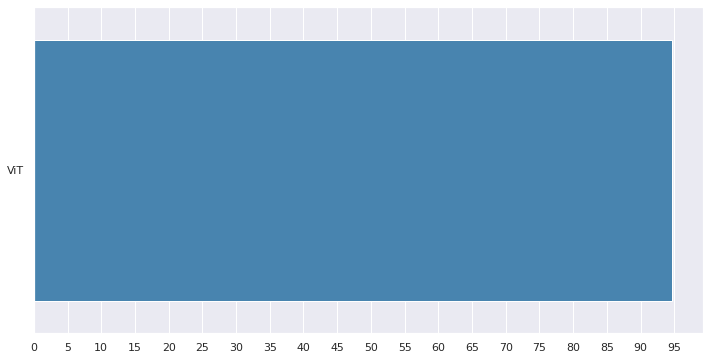

In [ ]:
def plot_model_accuracies():
    scores = []
    model_acc = {'ViT':vit_hard} #'vgg19BN':vgg19_bn_hard,  'DenseNet201':densenet201_hard,
                 #'EAInceptionResNetV2':ensemble_adv_incres_v2_hard, 'ResNeXt50':resnext50_hard}
    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(12,6)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="Blues_d", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_model_accuracies()

In [ ]:
def plot_confusion_matrix(preds, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    #getting the standard confusion matrix in text form
    cm = confusion_matrix(np.asarray(true_labels), np.asarray(preds))
    #using the matrix generated as means to plot a confusion matrix graphically
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix: Vision Transformer (ViT)

Confusion matrix, without normalization


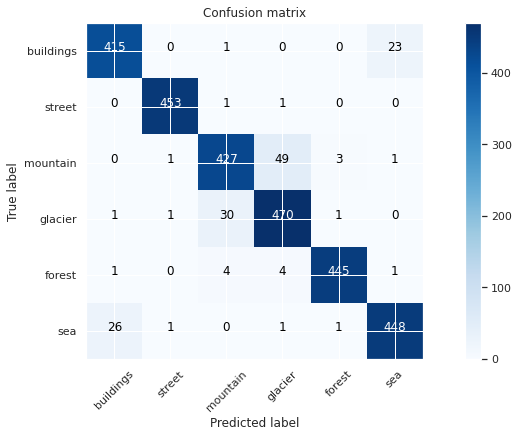

In [ ]:
plot_confusion_matrix(vit_hard, CLASSES)

In [ ]:
def predictions_df1(dl_model, test_loader, transform_obj):
    pred_hard, pred_soft = [], []
    correct_count, all_count = 0,0
    dl_model.eval()
    im_dim = transform_obj.transforms[1].size[0]
    with torch.no_grad():
        for images,_ in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                # labels = labels.cuda()
            for i in range(len(images)):
                img = images[i].view(1, 3, im_dim, im_dim)
                # soft voting
                output = dl_model(img)
                sm = nn.Softmax(dim=1)
                probabilities = sm(output)
                prob_arr = (probabilities.detach().cpu().numpy())[0]
                # hard voting
                logps = dl_model(img)
                ps = torch.exp(logps)
                probab = list(ps.cpu()[0])
                pred_label = probab.index(max(probab))
                # true_label = labels.cpu()[i]
                #exporting to dataframe
                pred_hard.append(pred_label)
                pred_soft.append(prob_arr)
                ####
                # if(true_label == pred_label):
                #     correct_count += 1
                # all_count += 1

    # print("Number of images Tested=", all_count)
    # print("Model Accuracy=",(correct_count/all_count)*100)
    print("\n")
    return pred_hard, pred_soft

In [ ]:
test_dir = "/content/test"

In [ ]:
test_data_v1 = ImageFolderWithPaths(test_dir, transform = transform_test_v1)
test_loader_v1 = torch.utils.data.DataLoader(test_data_v1, BATCH_SIZE, shuffle=False)


test_data_vit = ImageFolderWithPaths(test_dir, transform = transform_vit)
#loading data for ViT
test_loader_vit = torch.utils.data.DataLoader(test_data_vit, BATCH_SIZE, shuffle=False)


# test_data_eairv = ImageFolder(test_dir, transform = transform_eairv)
# #loading data for Ensemble Adversarial Inception-ResNetV2
# test_loader_eairv = torch.utils.data.DataLoader(test_data_eairv, BATCH_SIZE, shuffle=False)

In [ ]:
# vgg19_bn_hard, vgg19_bn_soft = predictions_df(model_vgg, test_loader_v1, transform_test_v1)
vit_hard, vit_soft = predictions_df1(model_vit, test_loader_vit, transform_vit)
# densenet201_hard, densenet201_soft = predictions_df(model_dn, test_loader_v1, transform_test_v1)
# ensemble_adv_incres_v2_hard, ensemble_adv_incres_v2_soft = predictions_df(model_eairv, test_loader_eairv, transform_eairv)
# resnext50_hard, resnext50_soft = predictions_df(model_rnx, test_loader_v1, transform_test_v1)

## file

In [ ]:
paths = []
for _, labels,path in test_data_v1:
    for x in range(len(path)):
        paths.append(path)
paths

['/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/0.jpg',
 '/content/test/forest/1.jpg',
 '/content/test/forest/1.jpg',
 '/content/test/forest/1.jpg',
 '/content/test/forest/1.jpg',
 '/content/test/forest/1.jpg',
 '/content/test/forest/1.jpg',
 '/conte

In [ ]:
len(paths)

85890

In [ ]:
submit = pd.DataFrame({
    'id': paths,
})

In [ ]:
submit=submit.drop_duplicates()

In [ ]:
submit['label']=vit_hard

In [ ]:
submit.id=submit.id.str.split('/').str[-1]
submit.id=submit.id.str.split('.').str[0]
submit

,id,label
0,0,5
26,1,4
52,10,0
79,100,5
107,1000,5
...,...,...
85750,995,4
85778,996,2
85806,997,2
85834,998,4


In [ ]:
submission_df = submit.sort_values("id")
submission_df.to_csv('submission16.csv', index=False)

In [ ]:
submission_df

,id,label
0,0,5
26,1,4
52,10,0
79,100,5
107,1000,5
...,...,...
85750,995,4
85778,996,2
85806,997,2
85834,998,4
